In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from scipy.integrate import odeint 
import time

2024-10-25 01:35:11.750901: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-25 01:35:11.760317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-25 01:35:11.771251: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-25 01:35:11.774558: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-25 01:35:11.782729: I tensorflow/core/platform/cpu_feature_guar

In [4]:
train_window = 15

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L,dim = (input_data).shape
    for i in range(L-tw):
        train_seq = input_data[i:i+tw,:]
        train_label = input_data[i+tw:i+tw+1,:]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [7]:
# Parametros
zeta = 0.1                # Fator de amortecimento
k = 2.0                   # Constante da mola
m = 1.0                   # Massa
omega_n = np.sqrt(k*m)    # Frequencia natural
F0 = 5.0                  # Modulo da força
t = np.arange(0, 10.1, 0.1)  # Tempo dt = 0.1

def oscilatorio_simples(y,t):
    u1 = y[1]
    u0 = y[0]
    return [u1, -k/m*u0]

def oscilador_forcado(y, t):
    x1, x2 = y
    dydt = [x2, -2 * zeta * omega_n * x2 - omega_n**2 * x1 + F0*np.cos(omega_n*t)]
    return dydt

def oscilador_amortecido(y, t):
    x1, x2 = y
    dydt = [x2, -2 * zeta * omega_n * x2 - omega_n**2 * x1]
    return dydt
posicoes = np.random.uniform(-10,10,5)
velocidades = np.random.uniform(-5,5,5)

def gerar_in_out(func,cont):
    posicao = posicoes[cont]
    velocidade = velocidades[cont]
    y0 = [posicao,velocidade]   # Condicoes iniciais: [x0, v0]
    solucao = odeint(func, y0, t)

    #Scalling manual Z score (x - x_mean)/(x_std)
    mean = np.mean(solucao,axis=(0))
    std = np.std(solucao,axis=(0))

    inputs_normalizados = (solucao-mean)/(std)

    sequencias = create_inout_sequences(inputs_normalizados,train_window) 
    train_inputs = tf.convert_to_tensor([sequencias[i][0] for i in range(len(sequencias))],dtype=tf.float32)
    train_outputs = tf.reshape(tf.convert_to_tensor([sequencias[i][1] for i in range(len(sequencias))],dtype=tf.float32),(-1,2))
    return mean,std,posicao,velocidade,train_inputs,train_outputs




In [77]:
def prever_e_plotar(posicao,velocidade,mean,std,model_keras,func,save,filepath,titulo):
    t_final = 15
    y0 = [posicao,velocidade]   # Condicoes iniciais: [x0, v0]
    t_pontos = np.arange(0,t_final+0.1,0.1)
    sol2 = odeint(func, y0, t_pontos)
    previsoes = ((sol2[:train_window,:]-mean)/std).tolist()
    sol2 = (sol2-mean)/std
    for i in range(101-train_window+t_final*10-100):
        prev_temp = model_keras((np.array([previsoes[k][:] for k in range(i,train_window+i)]).reshape(-1,train_window,2)))
        previsoes.append(prev_temp.numpy().tolist()[0])
    previsoes = np.array(previsoes)*std+mean
    sol2 = sol2*std+mean

    plt.figure(figsize=(10,5))
    x = sol2[:,0]
    v =  sol2[:,1]
    x_2 = previsoes[:,0]
    v_2= previsoes[:,1]


    t_pontos = np.arange(0,t_final+0.1,0.1)
    print(f"MSE: {(tf.reduce_mean(tf.square(previsoes[train_window:101]-sol2[train_window:101])))}")
    print(f"MAE: {(tf.reduce_mean(tf.abs(previsoes[train_window:101]-sol2[train_window:101])))}")
    plt.plot(t_pontos[train_window:], x[train_window:], 'bo', label="Posição Original",markersize=2.6)
    plt.plot(t_pontos[train_window:], x_2[train_window:], 'r-', label="Posição Prevista")
    plt.plot(t_pontos[train_window:], v[train_window:], 'c--o', label="Velocidade Original",markersize=2.6)
    plt.plot(t_pontos[train_window:], v_2[train_window:], 'm--', label="Velocidade Prevista")
    plt.xlabel("Tempo (s)")
    plt.ylabel("X (m); V (m/s)")
    plt.title(titulo)
    plt.grid(1)
    plt.legend()
    if save:
        plt.savefig(filepath)
    else:
        plt.show()


Média: [-0.34513911  1.09041338], Desvio Padrão: [5.48860185 8.07284894]
Posição: -7.4476743107910455, Velocidade: 3.988974451771707

MSE: 3.229055588652858e-06
MAE: 0.00149287694481047


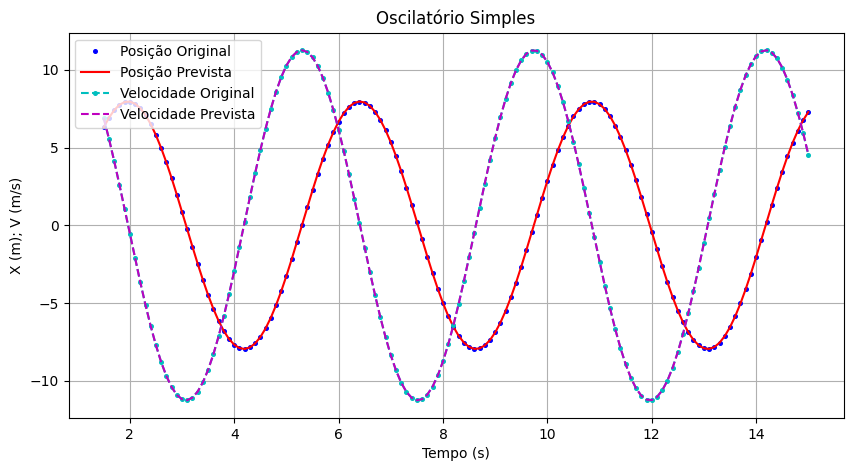

In [79]:
for i in range(4,5): 
    mean,std,posicao,velocidade,train_inputs,train_outputs = gerar_in_out(oscilatorio_simples,i)


    print(f"Média: {mean}, Desvio Padrão: {std}")
    print(f"Posição: {posicao}, Velocidade: {velocidade}")

    model_keras = Sequential([
        Input((train_window,2)),
        LSTM(256, return_sequences=1),
        LSTM(128, return_sequences=0),
        (Dense(2))])

    model_keras.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,amsgrad=1), loss="mse",metrics=["mae"])
    history = model_keras.fit(train_inputs,train_outputs,epochs=1000,batch_size=8, verbose = 0)
    print()

    prever_e_plotar(posicao,velocidade,mean,std,model_keras,oscilatorio_simples,save=1,filepath="imagens/osc_simples_unico.png",titulo="Oscilatório Simples")


Média: [-0.07277526  0.80673072], Desvio Padrão: [3.10734421 4.52492715]
Posição: -7.4476743107910455, Velocidade: 3.988974451771707

MSE: 4.9694795083073546e-05
MAE: 0.006221390893494124


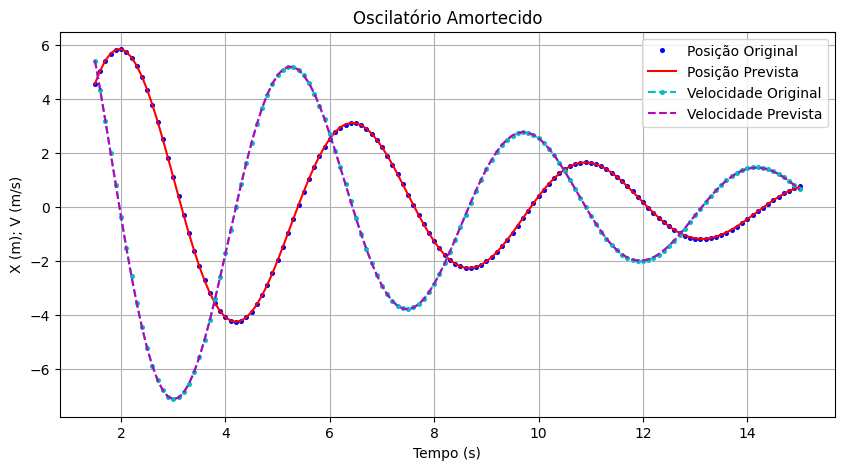

In [78]:
for i in range(4,5): 
    mean,std,posicao,velocidade,train_inputs,train_outputs = gerar_in_out(oscilador_amortecido,i)


    print(f"Média: {mean}, Desvio Padrão: {std}")
    print(f"Posição: {posicao}, Velocidade: {velocidade}")

    model_keras = Sequential([
        Input((train_window,2)),
        LSTM(256, return_sequences=1),
        LSTM(128, return_sequences=0),
        (Dense(2))])

    model_keras.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001,amsgrad=0), loss="mse",metrics=["mae"])
    history = model_keras.fit(train_inputs,train_outputs,epochs=1000,batch_size=8, verbose = 0)
    print()

    prever_e_plotar(posicao,velocidade,mean,std,model_keras,oscilador_amortecido,save=1,filepath="imagens/osc_amort_unico.png",titulo="Oscilatório Amortecido")


Média: [0.01372258 1.74091397], Desvio Padrão: [5.80689673 8.80368757]
Posição: -7.4476743107910455, Velocidade: 3.988974451771707
Epoch 1/1000
11/11 - 1s - 89ms/step - loss: 0.8628 - mae: 0.8261
Epoch 2/1000
11/11 - 0s - 4ms/step - loss: 0.5304 - mae: 0.6420
Epoch 3/1000
11/11 - 0s - 9ms/step - loss: 0.2479 - mae: 0.4256
Epoch 4/1000
11/11 - 0s - 4ms/step - loss: 0.0656 - mae: 0.2073
Epoch 5/1000
11/11 - 0s - 4ms/step - loss: 0.0100 - mae: 0.0787
Epoch 6/1000
11/11 - 0s - 9ms/step - loss: 0.0112 - mae: 0.0853
Epoch 7/1000
11/11 - 0s - 4ms/step - loss: 0.0053 - mae: 0.0600
Epoch 8/1000
11/11 - 0s - 4ms/step - loss: 0.0046 - mae: 0.0570
Epoch 9/1000
11/11 - 0s - 9ms/step - loss: 0.0042 - mae: 0.0533
Epoch 10/1000
11/11 - 0s - 4ms/step - loss: 0.0040 - mae: 0.0519
Epoch 11/1000
11/11 - 0s - 4ms/step - loss: 0.0040 - mae: 0.0516
Epoch 12/1000
11/11 - 0s - 9ms/step - loss: 0.0040 - mae: 0.0525
Epoch 13/1000
11/11 - 0s - 4ms/step - loss: 0.0040 - mae: 0.0527
Epoch 14/1000
11/11 - 0s - 4ms/s

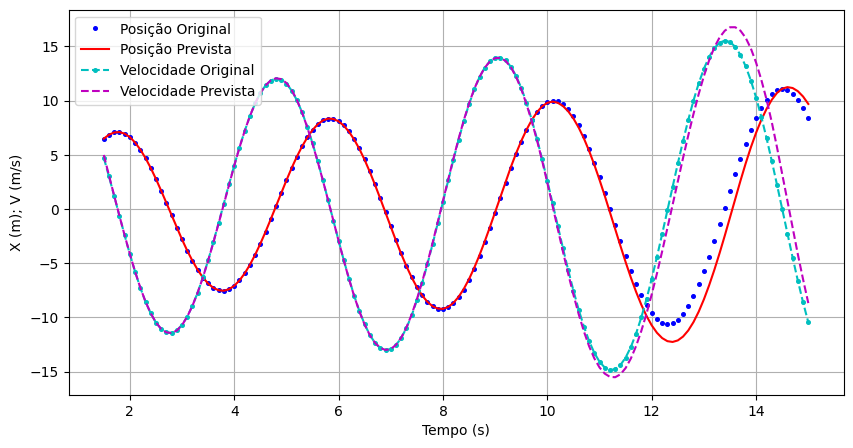

In [71]:
for i in range(4,5): 
    mean,std,posicao,velocidade,train_inputs,train_outputs = gerar_in_out(oscilador_forcado,i)


    print(f"Média: {mean}, Desvio Padrão: {std}")
    print(f"Posição: {posicao}, Velocidade: {velocidade}")

    model_keras = Sequential([
        Input((train_window,2)),
        LSTM(256, return_sequences=1),
        LSTM(128, return_sequences=0),
        (Dense(2))])

    model_keras.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,amsgrad=1), loss="mse",metrics=["mae"])
    history = model_keras.fit(train_inputs,train_outputs,epochs=1000,batch_size=8, verbose = 2)
    print()

    prever_e_plotar(posicao,velocidade,mean,std,model_keras,oscilador_forcado,save=1,filepath="imagens/osc_forc_unico.png",titulo="Oscilatório Forçado")
